In [4]:
# importing all relative packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

disease_data = "..\data\Heart_disease.csv"
df_disease = pd.read_csv(disease_data)

# My chosen dataframe was dataframe 2 
df_two = df_disease.drop(columns=["BMI_cat", "bp_category", "height", "weight"])
df_two = pd.get_dummies(df_two, columns=["gender"])
df_two.rename(columns= {"gender_1" : "female", "gender_2" : "male"}, inplace=True)

X,y = df_two.drop("cardio", axis = "columns"), df_two["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

standard_scaler = StandardScaler()
X_train_scaled= standard_scaler.fit_transform(X_train)
X_test_scaled= standard_scaler.transform(X_test)

In [5]:
df_two.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,female,male
0,1,55.38,140,90,3,1,0,0,1,1,34.93,1,0
1,3,48.25,150,100,1,1,0,0,1,1,28.71,0,1
2,12,61.83,130,90,3,3,0,0,1,1,29.98,0,1
3,32,63.10,145,85,2,2,0,0,1,1,36.05,1,0
4,46,60.07,140,90,3,1,0,0,0,1,27.40,0,1


# Training my chosen dataset and model

My chosen model was a random forest model. These were the scores that it had using the Grid search CV. I have also the best parameters that were evaluated. This was using the standard scaler.

- best score 0.73
- best params{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}
- best estimator 0.73

In [6]:
# importing randomforest classifier and accuracy score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# creating model with my best hyper parameters
model = RandomForestClassifier(criterion= "entropy", max_features="log2", n_estimators=150)
# Fitting my model to the training data
model.fit(X_train_scaled, y_train)

# predictions from X test
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy after testing on test data  {accuracy}")


Model Accuracy after testing on test data  0.7337314346960649


# Confusion matrix on my chosen model

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      3102
           1       0.75      0.74      0.75      3429

    accuracy                           0.73      6531
   macro avg       0.73      0.73      0.73      6531
weighted avg       0.73      0.73      0.73      6531



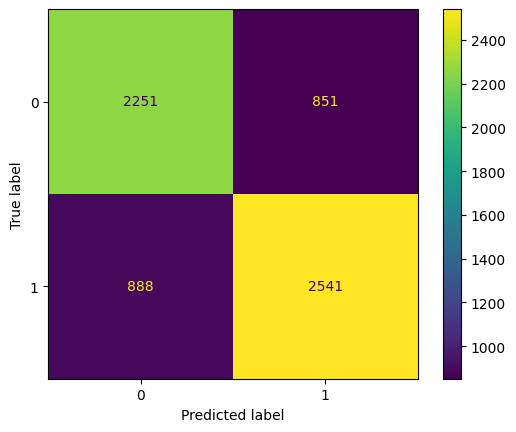

In [7]:
# importing confusion matrix so I can access my model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

print(classification_report(y_test, y_pred))

# using y test and y pred to evaluate
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

As we can see from the classification report both 0(NO) and 1(Yes) have had similar precision and recall results. The F1 score which is a weighted average of both precision and recall has given 0.72 for 0 and 0.75 for 1. We can say that this is a fairly accurate model from these result, but does need improvement. I will try an Ensemble of the different models which I trained, with the best hyper parameters to see if it will improve the results.

## 2.5 Ensemble

Voting classifier accuracy:0.7325065074261216
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      3102
           1       0.76      0.72      0.74      3429

    accuracy                           0.73      6531
   macro avg       0.73      0.73      0.73      6531
weighted avg       0.73      0.73      0.73      6531



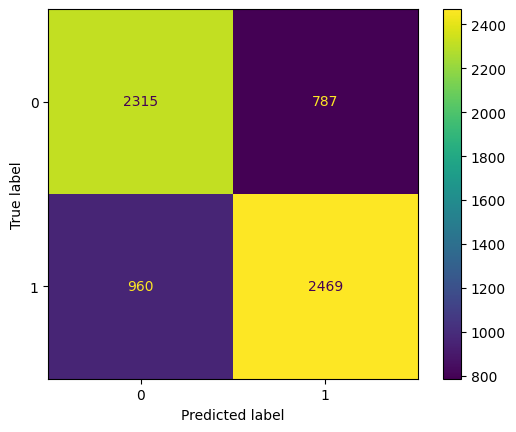

In [8]:
# importing voting classifier for combining the different models
from sklearn.ensemble import VotingClassifier
# Importing Random forest, Logistic Regression and Naive bayes Bernoulli
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
# classification report anf confusion matrix to visualize the results
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# The 3 models with the best hyper parameters
model_1 = RandomForestClassifier(criterion= "entropy", max_features="log2", n_estimators=150)
model_2 = LogisticRegression(C= 0.026366508987303583, penalty="l1",solver="saga")
model_3 = BernoulliNB(alpha=10, binarize=0.0, fit_prior=True)

# initializing the voting classifier with the 3 models
voting_clf = VotingClassifier(estimators=[("rf", model_1),("lr", model_2), ("bn", model_3)], voting="soft")

# Scaling the model to the x train and y train 
voting_clf.fit(X_train_scaled,y_train)

# predicting the cardio result using X test now
y_pred = voting_clf.predict(X_test_scaled)

print(f"Voting classifier accuracy:{voting_clf.score(X_test_scaled, y_test)}")

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

When looking at the results of the ensemble model, we can see that there is not a lot of difference between the two. 
However the second model has slightly higher precision in class 1 and a slightly higher recall in class 0. This means that that model may have a better chance at detecting in the cases where people do have a cardiovascular disease. I think this sways me to using the second model as we want to know in the instances that people have a cardio disease so they are not missed if they require treatment. 

## 2.7 "Deploy"- save model

### Taking 100 random test samples from the dataframe

In [9]:
# This selects which rows are to be moved from the data frame
remove_rows = df_two.sample(n=100, random_state=42).index
# This removes the 100 rows and creates another data frame with them
df_test_samples = df_two.loc[remove_rows]
# This drops the chosen 100 rows from the original data frame
df_train = df_two.drop(remove_rows)

In [17]:
df_test_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 8850 to 16745
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           100 non-null    int64  
 1   age          100 non-null    float64
 2   ap_hi        100 non-null    int64  
 3   ap_lo        100 non-null    int64  
 4   cholesterol  100 non-null    int64  
 5   gluc         100 non-null    int64  
 6   smoke        100 non-null    int64  
 7   alco         100 non-null    int64  
 8   active       100 non-null    int64  
 9   cardio       100 non-null    int64  
 10  BMI          100 non-null    float64
 11  female       100 non-null    uint8  
 12  male         100 non-null    uint8  
dtypes: float64(2), int64(9), uint8(2)
memory usage: 9.6 KB


In [18]:
df_train.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,female,male
0,1,55.38,140,90,3,1,0,0,1,1,34.93,1,0
1,3,48.25,150,100,1,1,0,0,1,1,28.71,0,1
2,12,61.83,130,90,3,3,0,0,1,1,29.98,0,1
3,32,63.10,145,85,2,2,0,0,1,1,36.05,1,0
4,46,60.07,140,90,3,1,0,0,0,1,27.40,0,1


In [12]:
# saving the test and train data to two csv files
df_train.to_csv("..\data\Train_data_disease.csv", index=False)
df_test_samples.to_csv("..\data\Test_data_disease.csv", index=False)

### Training final my model on all data except the 100 random chosen data

In [13]:
# importing a pipeline so i can have a scaler at the beginning of the model
from sklearn.pipeline import Pipeline

# dropping the cardio column from the data set
X,y = df_train.drop("cardio", axis = "columns"), df_train["cardio"]

# my chosen models and hyper paramters
model_1 = RandomForestClassifier(criterion= "entropy", max_features="log2", n_estimators=150)
model_2 = LogisticRegression(C= 0.026366508987303583, penalty="l1",solver="saga")
model_3 = BernoulliNB(alpha=10, binarize=0.0, fit_prior=True)

# the voting classifier model
voting_clf = VotingClassifier(estimators=[("rf", model_1),("lr", model_2), ("bn", model_3)], voting="soft")

# The pipeline that I will use that contains a Standard scaler then the voting classifier
pipe_clf = Pipeline([("scaler", StandardScaler()), ("clf",voting_clf)])
# firing the pipeling to the data
pipe_clf.fit(X,y)

# The prediction from my trained model
y_pred = pipe_clf.predict(X)

print(f"Voting classifier accuracy:{pipe_clf.score(X, y)}")

Voting classifier accuracy:0.8177570093457944


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      9463
           1       0.83      0.81      0.82     10225

    accuracy                           0.82     19688
   macro avg       0.82      0.82      0.82     19688
weighted avg       0.82      0.82      0.82     19688



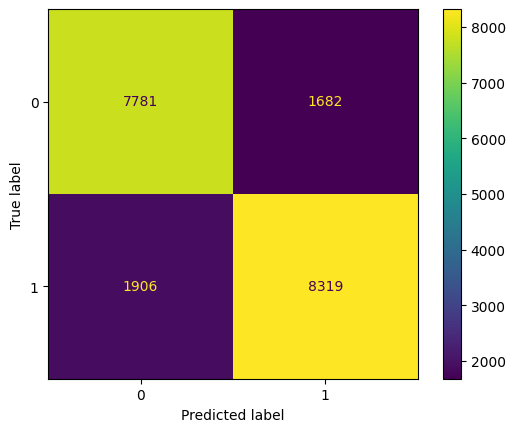

In [14]:
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()

As can see from the classification report and confusion matrix, this model improved when trained with a higher amount of data. The f1 scores are now up to 0.81 for 0(NO) and 0.82 for 1(YES). This is quite an improvement. 
I will now export the model as a file to be used for predictions

In [16]:
# importing pickle to create a file for the model
import pickle
# selecting the pipeline to be used in the file and naming it.
pickle.dump(pipe_clf, open ("voting_clf_model.pkl", "wb"))